# L4 data set

In [2]:
%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import pickle
from scipy import io

import time
import warnings

import glmnet_python
from glmnet import glmnet

import sparseRRR

# This file is from https://github.com/berenslab/rna-seq-tsne
import sys; sys.path.append('../rna-seq-tsne/')
import rnaseqTools

def sns_styleset():
    sns.set_context('paper')
    sns.set_style('ticks')
    matplotlib.rcParams['axes.linewidth']    = .75
    matplotlib.rcParams['xtick.major.width'] = .75
    matplotlib.rcParams['ytick.major.width'] = .75
    matplotlib.rcParams['xtick.major.size'] = 3
    matplotlib.rcParams['ytick.major.size'] = 3
    matplotlib.rcParams['font.size']       = 7
    matplotlib.rcParams['axes.titlesize']  = 7
    matplotlib.rcParams['axes.labelsize']  = 7
    matplotlib.rcParams['legend.fontsize'] = 7
    matplotlib.rcParams['xtick.labelsize'] = 7
    matplotlib.rcParams['ytick.labelsize'] = 7

In [ ]:
# Load L4 data

# Note: This takes a bit longer, you can also immediately load the pickled file (two boxes under this box) if available

data = pd.read_csv("../../BICCN patch-seq data/L4/rnaseq/counts.csv", sep='\t')
counts = data.values[:,1:].transpose().astype(float)
genes = data.values[:,0]
cells = np.array(data.columns[1:])

print('Number of cells: {}\nNumber of genes: {}'.format(counts.shape[0], counts.shape[1]))

meta = pd.read_excel('../../BICCN patch-seq data/L4/Layer 4 cells.xlsx', index_col=0)
d = [d[6:10]+d[:2]+d[3:5] for d in meta.values[1:,1] if d is not np.nan]
s = [s[7:].strip() if 'sample ' in s else s[6:].strip() for s in meta.values[1:,2] if s is not np.nan]
names = [d[i]+'_sample_'+s[i] for i in range(len(d))]
regions = [m for m in meta.values[1:,3] if m=='V1' or m=='S1']
layers = [m for m in meta.values[1:,4] if ~np.isnan(m)]
names2regions = dict(zip(names,regions))
names2layers = dict(zip(names,layers))

for h in cells:
    if '_'.join(h.split('_')[:3]) not in names2regions:
        print('NO META INFO: ' + h)
        
regions = np.array([names2regions['_'.join(c.split('_')[:3])] for c in cells])
layers  = np.array([names2layers['_'.join(c.split('_')[:3])] for c in cells])

ephysData = pd.read_csv('../layer4/ephys/data/patch-seq-ephys-features.csv')
ephysNames = np.array(ephysData.columns[1:-2])
ephysCells = np.array([s.split('sample')[0]+'_sample_'+s.split('sample')[1] for s in ephysData.values[:,0]])
keep = ephysData['Good quality']
ai0 = ephysData['AI']==0
ephysData = ephysData.values[:, 1:-2].astype('float')
ephysData[~keep,:] = np.nan
ephysData[keep, ephysNames=='Latency (ms)'] = np.log(ephysData[keep, ephysNames=='Latency (ms)'])
ephysData[keep & ~ai0, ephysNames=='AI'] = np.log(ephysData[keep & ~ai0, ephysNames=='AI']/100)
ephysData[ai0, ephysNames=='AI'] = np.nan
names2ephys = dict(zip(ephysCells, ephysData))
ephys = np.array([names2ephys['_'.join(c.split('_')[:3])] if '_'.join(c.split('_')[:3]) in names2ephys
          else np.ones(ephysNames.size)*np.nan for c in cells]).astype(float)

l4 = {'counts': counts, 'cells': cells, 'genes': genes, 
      'regions': regions, 'layers': layers, 'ephys': ephys,
      'ephysNames': ephysNames}

print('')
print(ephysNames)
print(ephysNames.size)

In [ ]:
pickle.dump(l4, open('l4data.pickle', 'wb'))

In [3]:
l4 = pickle.load(open('L4Data/l4data.pickle', 'rb'))

102
Chosen offset: 7.08


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/L4/ReAnalysis/WithRheobaseAndSag/rnaseqTools.py:46: RuntimeWarning: divide by zero encountered in log2
  meanExpr[detected] = np.nanmean(np.where(data[:,detected]>threshold, np.log2(data[:,detected]), np.nan), axis=0)


<IPython.core.display.Javascript object>


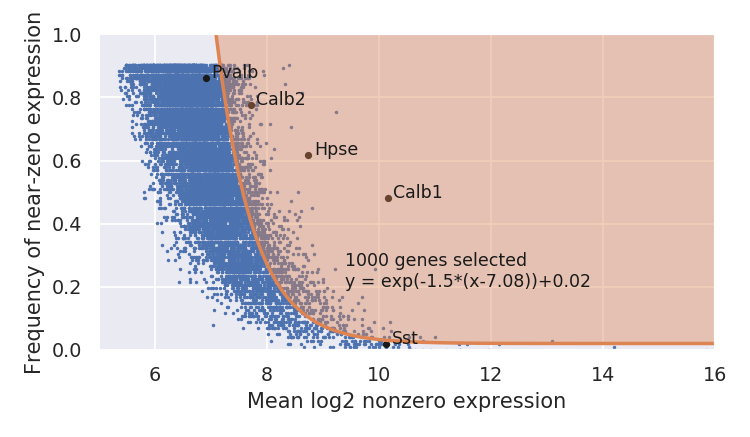

Shape of X: (102, 1000) 
Shape of Y: (102, 13)


In [4]:
# cells to exclude based on RNA (either low quality or mapps to PV/excitatory)
exclude = ['20180605_sample_12_L4_S109', '20180626_sample_11_L4_S129',
           '20180703_sample_6_L4_S157', '20180919_sample_21_L4_S136',
           '20180605_sample_17_L4_S114', '20180626_sample_7_L4_S125',
           '20180627_sample_1_L4_S137', '20180703_sample_4_L4_S154']

selection = ~np.isin(l4['cells'], exclude) & ~np.isnan(np.sum(l4['ephys'],axis=1))
print(np.sum(selection))

genesForRRR = rnaseqTools.geneSelection(l4['counts'][selection,:], n=1000, threshold=32, decay=1.5, 
                                     markers=['Sst', 'Pvalb', 'Hpse', 'Calb2', 'Calb1', 'Mme', 'Tac1', 'Tac2'],
                                     genes=l4['genes'])

X_raw = l4['counts'][selection, :] # To test whether cv is performed ok by standard
X = l4['counts'][selection,:] / np.sum(l4['counts'][selection,:], axis=1, keepdims=True) * 1e+6
X = np.log2(X + 1)

X = X[:, genesForRRR]
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)

Y_raw = l4['ephys'][selection, :] # To test whether cv is performed ok by standard

Y = l4['ephys'][selection,:]
Y = Y - np.mean(Y, axis=0)
Y = Y / np.std(Y, axis=0)

print('Shape of X:', X.shape, '\nShape of Y:', Y.shape)

<IPython.core.display.Javascript object>


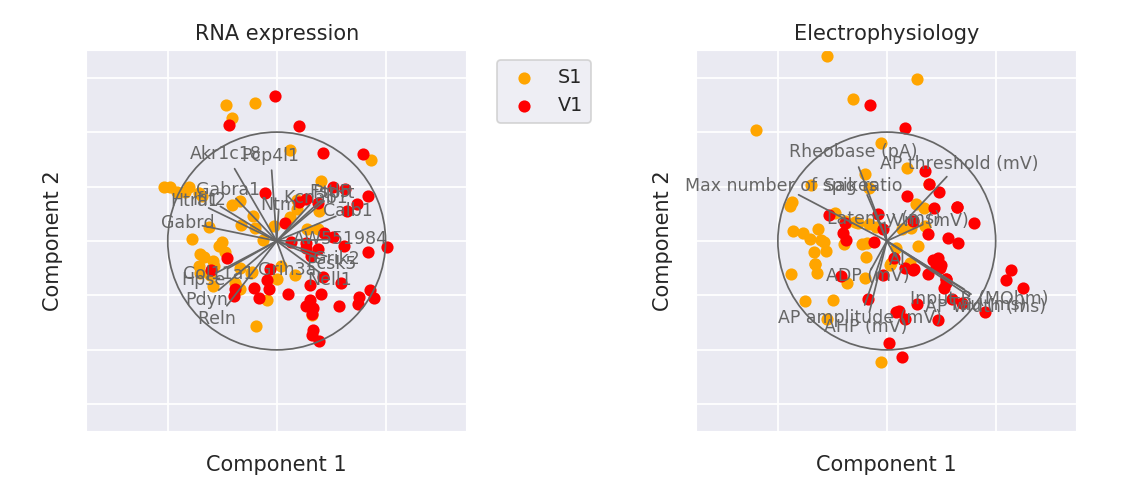

In [5]:
w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=1, alpha=.5)

sparseRRR.bibiplot(X, Y, w, v, 
                   titles=['RNA expression', 'Electrophysiology'],
                   cellTypes=l4['regions'][selection], 
                   cellTypeColors={'V1':'red','S1':'orange'}, 
                   cellTypeLabels = {'V1':'V1','S1':'S1'}, 
                   YdimsNames=l4['ephysNames'], XdimsNames=l4['genes'][genesForRRR],
                   xylim = 3.5)

# Are we leaking information from train to validation set with our initial standardisation and gene selection?

Here we check whether there is any significant (whatever that might mean) difference between cross validation as we usually perform it and how Yves suggested it to do.

In [8]:
# So here's another function

# Cross-validation for elastic net reduced-rank regression
def elastic_rrr_cv_gene_selection(X, Y, alphas = np.array([.2, .5, .9]), lambdas = np.array([.01, .1, 1]), 
                   reps=10, folds=10, rank=1, seed=42, n_=1000, threshold_=32, decay_ = 1.5, plotting = False):
    
    # Like standard elastic_rrr_cv but now we use the heuristic to select genes for every training set for X
    # that we consider. Variables that our important for this gene selection end with an underscore '_'
    
    n = X.shape[0]
    r2 = np.zeros((folds, reps, len(lambdas), len(alphas)))
    r2_relaxed = np.zeros((folds, reps, len(lambdas), len(alphas)))
    corrs = np.zeros((folds, reps, len(lambdas), len(alphas), rank))
    corrs_relaxed = np.zeros((folds, reps, len(lambdas), len(alphas), rank))
    nonzero = np.zeros((folds, reps, len(lambdas), len(alphas)))

    # CV repetitions
    np.random.seed(seed)
    t = time.time()
    for rep in range(reps):
        print(rep+1, end='')
        ind = np.random.permutation(n)
        X = X[ind,:]
        Y = Y[ind,:]
        
        # CV folds
        for cvfold in range(folds):
            print('.', end='')

            indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
            indtrain = np.setdiff1d(np.arange(n), indtest)
            Xtrain = np.copy(X[indtrain,:])
            Ytrain = np.copy(Y[indtrain,:])
            Xtest  = np.copy(X[indtest,:])
            Ytest  = np.copy(Y[indtest,:])
            
            print('Xtrain shape: ', Xtrain.shape)
            # Now let's select genes based on the heuristic
            selectedGenes = rnaseqTools.geneSelection(Xtrain, n=n_, threshold = threshold_, decay = decay_, plot = plotting)
            
            Xtrain = Xtrain / np.sum(Xtrain, axis=1, keepdims = True) * 1e+6
            Xtrain = np.log2(Xtrain + 1)
            Xtest = Xtest / np.sum(Xtest, axis = 1, keepdims = True) * 1e+6
            Xtest = np.log2(Xtest + 1)
            
            Xtrain = Xtrain[:, selectedGenes]
            #print('std of Xtrain after geneSelection: \n', np.std(Xtrain, axis = 0))
            Xtest = Xtest[:, selectedGenes]
            print('Xtrain shape: ', Xtrain.shape)
            print('Xtest shape: ', Xtest.shape)

            
            mu = np.mean(Xtrain, axis = 0)
            Xtrain = Xtrain - mu
            Xtest = Xtest - mu
            
            std = np.std(Xtrain, axis = 0)
            Xtrain = Xtrain / std
            Xtest = Xtest / std
            
            # We assume we get the raw Y matrix here too, so standardisation is appropriate
            # If not your test R^2 would be dominated by the largest feature (differences will be bigger there)
            mu = np.mean(Ytrain, axis = 0)
            Ytrain = Ytrain - mu
            Ytest = Ytest - mu
            
            std = np.std(Ytrain, axis = 0)
            Ytrain = Ytrain / std
            Ytest = Ytest / std
            
            # Should the following not have already been performed??
            # mean centering
            #X_mean = np.mean(Xtrain, axis=0)
            #Xtrain -= X_mean
            #Xtest  -= X_mean
            #Y_mean = np.mean(Ytrain, axis=0)
            #Ytrain -= Y_mean
            #Ytest  -= Y_mean
            
            # loop over regularization parameters
            for i,a in enumerate(lambdas):    
                for j,b in enumerate(alphas):
                    vx,vy = sparseRRR.elastic_rrr(Xtrain, Ytrain, lambdau=a, alpha=b, rank=rank)
                    
                    if np.sum(vx[:,0]!=0) < rank:
                        nonzero[cvfold, rep, i, j] = np.nan
                        continue
                    
                    nonzero[cvfold, rep, i, j] = np.sum(vx[:,0]!=0)
                    r2[cvfold, rep, i, j] = 1 - np.sum((Ytest - Xtest @ vx @ vy.T)**2) / np.sum(Ytest**2)
                    for r in range(rank):
                        corrs[cvfold, rep, i, j, r] = np.corrcoef(Xtest @ vx[:,r], Ytest @ vy[:,r], rowvar=False)[0,1]
                        
                    # Relaxation
                    vx[vx[:,0]!=0,:],vy = sparseRRR.elastic_rrr(Xtrain[:,vx[:,0]!=0], Ytrain, lambdau=a, alpha=0, rank=rank)
                    r2_relaxed[cvfold, rep, i, j] = 1 - np.sum((Ytest - Xtest @ vx @ vy.T)**2) / np.sum(Ytest**2)
                    for r in range(rank):
                        corrs_relaxed[cvfold, rep, i, j, r] = np.corrcoef(Xtest @ vx[:,r], Ytest @ vy[:,r], rowvar=False)[0,1]
                    
        print(' ', end='')
    
    t = time.time() - t
    m,s = divmod(t, 60)
    h,m = divmod(m, 60)
    print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))
    
    return r2, r2_relaxed, nonzero, corrs, corrs_relaxed

1.......... 2.......... 3.......... 4.......... Time: 0.0h  6m 57s


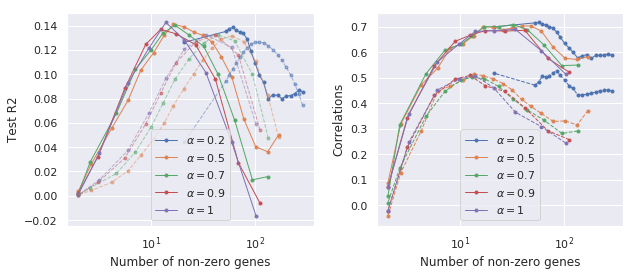

In [24]:
lambdas = np.concatenate([np.arange(.1, 2, .1), np.arange(2, 4)])
alphas = [.2, .5, .7, .9, 1]

r2, r2_relaxed, nonzero, corrs, corrs_relaxed = sparseRRR.elastic_rrr_cv(
    X, Y, rank=2, reps=4, folds=10, alphas=alphas, lambdas=lambdas)

sparseRRR.plot_cv_results(r2, r2_relaxed, nonzero, corrs, corrs_relaxed, alphas)
plt.savefig('cv_normal.png')

1.Xtrain shape:  (92, 26514)
Chosen offset: 7.09
Xtrain shape:  (92, 1000)
Xtest shape:  (10, 1000)


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/L4/ReAnalysis/WithRheobaseAndSag/rnaseqTools.py:46: RuntimeWarning: divide by zero encountered in log2
  meanExpr[detected] = np.nanmean(np.where(data[:,detected]>threshold, np.log2(data[:,detected]), np.nan), axis=0)


.Xtrain shape:  (92, 26514)
Chosen offset: 7.08
Xtrain shape:  (92, 1000)
Xtest shape:  (10, 1000)
.Xtrain shape:  (92, 26514)
Chosen offset: 7.07
Xtrain shape:  (92, 1000)
Xtest shape:  (10, 1000)
.Xtrain shape:  (92, 26514)
Chosen offset: 7.11
Xtrain shape:  (92, 1000)
Xtest shape:  (10, 1000)
.Xtrain shape:  (92, 26514)
Chosen offset: 7.09
Xtrain shape:  (92, 1000)
Xtest shape:  (10, 1000)
.Xtrain shape:  (92, 26514)
Chosen offset: 7.06
Xtrain shape:  (92, 1000)
Xtest shape:  (10, 1000)
.Xtrain shape:  (92, 26514)
Chosen offset: 7.06
Xtrain shape:  (92, 1000)
Xtest shape:  (10, 1000)
.Xtrain shape:  (92, 26514)
Chosen offset: 7.07
Xtrain shape:  (92, 1000)
Xtest shape:  (10, 1000)
.Xtrain shape:  (92, 26514)
Chosen offset: 7.06
Xtrain shape:  (92, 1000)
Xtest shape:  (10, 1000)
.Xtrain shape:  (92, 26514)
Chosen offset: 7.10
Xtrain shape:  (92, 1000)
Xtest shape:  (10, 1000)
 2.Xtrain shape:  (92, 26514)
Chosen offset: 7.06
Xtrain shape:  (92, 1000)
Xtest shape:  (10, 1000)
.Xtrain 

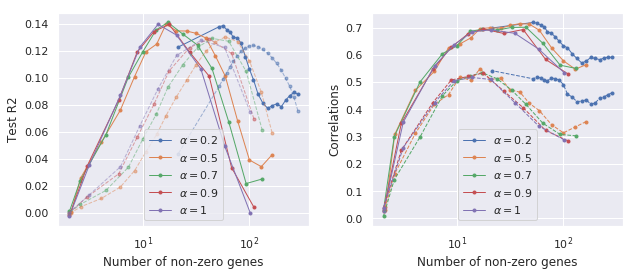

In [25]:
lambdas = np.concatenate([np.arange(.1, 2, .1), np.arange(2, 4)])
alphas = [.2, .5, .7, .9, 1]
r2, r2_relaxed, nonzero, corrs, corrs_relaxed = elastic_rrr_cv_gene_selection(
    X_raw, Y_raw, rank=2, reps=4, folds=10, alphas=alphas, lambdas=lambdas)

sparseRRR.plot_cv_results(r2, r2_relaxed, nonzero, corrs, corrs_relaxed, alphas)
plt.savefig('cv_Yves.png')

We can conclude that we don't, the differences between cross validation curves seem to be incredibly small.

# sRRR vs Witten et al. sCCA, 1st correlation component

The latency and AI are properly log transformed (the AI after dividing by 100) in Y here (see preprocessing (if not, please do so) and X and Y are mean centered and scaled (again, if not, do so). To compare the first correlation component between the three methods, sRRR should work with rank = 1. Make sure that the cross validation procedure is the same between methods (same seed!).

In [8]:
# Setting the seed will lead to the same training and test set for the different cross validation methods!
# You can check this by running the following code multiple times:

#seed = 42
#np.random.seed(seed)
#ind = np.random.permutation(50)
#ind

In [10]:
# Kobak et al (sRRR)
# Cross-validation to select lambda and alpha
# Rank = 1, alpha = 1 added

lambdas = np.concatenate([np.arange(.1, 2, .1), np.arange(2, 4)])
alphas = [.2, .5, .7, .9, 1]

r2, r2_relaxed, nonzeros, corrs, corrs_relaxed = sparseRRR.elastic_rrr_cv(X, Y, 
        lambdas=lambdas, alphas=alphas, reps = 5, rank=1, folds=10, seed = 42)

with open('kobakcv_L4.pickle', 'wb') as f:
    pickle.dump([r2, r2_relaxed, nonzeros, corrs, corrs_relaxed], f)

1.......... 2.......... 3.......... 4.......... 5......

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


.... Time: 0.0h  6m 14s


In [18]:
# Witten et al (diagonal penalised CCA called there, but in essence it is sPLS)

def softthresh(x,mu):
    return np.sign(x) * np.maximum(np.abs(x) - mu, 0)

def sparsepls(X, Y, lx=0, ly=0):
    A = X.T @ Y
    u,s,v = np.linalg.svd(A, full_matrices=False)
    u = u[:,0]
    v = v[0,:]
    
    for i in range(100):
        unew = softthresh(A @ v, lx)
        if np.linalg.norm(unew) > 0:
            unew = unew / np.linalg.norm(unew)
        vnew = softthresh(A.T @ unew, ly)
        if np.linalg.norm(vnew) > 0:
            vnew = vnew / np.linalg.norm(vnew)
        
        if np.sum((u-unew)**2) + np.sum((v-vnew)**2) < 1e-10:
#             print(i, 'iterations')
            break
        else:
            u = unew
            v = vnew
    
    return (u,v)

%time u,v = sparsepls(X, Y, lx=74)
print(np.sum(u != 0), 'non-zero genes:', l4['genes'][genesForRRR][u!=0])

CPU times: user 428 ms, sys: 1.35 s, total: 1.78 s
Wall time: 54.7 ms
6 non-zero genes: ['Gabrd' 'Htra1' 'Grik2' 'Gabra1' 'Akr1c18' 'Ifit2']


In [12]:
def wittencv(X, Y, reg_params, reps=100, folds=11):
    n = X.shape[0]
    testcorrs = np.zeros((folds, reps, len(reg_params)))
    nonzero = np.zeros((folds, reps, len(reg_params)))

    # CV repetitions
    np.random.seed(42)
    for rep in range(reps):
        print(rep, end=' ')
        ind = np.random.permutation(n)
        X = X[ind,:]
        Y = Y[ind,:]
        
        # CV folds
        for cvfold in range(folds):
            indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
            indtrain = np.setdiff1d(np.arange(n), indtest)
            Xtrain = np.copy(X[indtrain,:])
            Ytrain = np.copy(Y[indtrain,:])
            Xtest  = np.copy(X[indtest,:])
            Ytest  = np.copy(Y[indtest,:])
            
            # mean centering
            X_mean = np.mean(Xtrain, axis=0)
            Xtrain -= X_mean
            Xtest  -= X_mean
            Y_mean = np.mean(Ytrain, axis=0)
            Ytrain -= Y_mean
            Ytest  -= Y_mean

            # loop over regularization parameters
            for i,r in enumerate(reg_params):    
                vx,vy = sparsepls(Xtrain, Ytrain, lx=r)
                testcorrs[cvfold, rep, i] = np.corrcoef((Xtest @ vx).T, (Ytest @ vy).T)[0,1]
                nonzero[cvfold, rep, i] = np.sum(vx!=0)
    return testcorrs, nonzero

params = np.concatenate([np.arange(34, 79, 5)])
%time corrs, nonzeros = wittencv(X, Y, params, reps=50)
c = np.nanmean(np.nanmean(corrs, axis=1), axis=0)
n = np.mean(np.mean(nonzeros, axis=1), axis=0)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 CPU times: user 7min 34s, sys: 23min 4s, total: 30min 38s
Wall time: 46.2 s


<IPython.core.display.Javascript object>


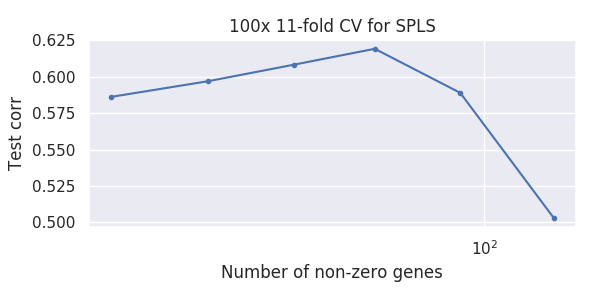

Optimal param:  44
Optimal n:  55.723636363636366
Optimal correlation:  0.619261201343654


In [13]:
# Pickling Witten et al. sCCA results
with open('wittencv_L4.pickle', 'wb') as f:
    pickle.dump([c, n, corrs, nonzeros], f)
plt.figure(figsize=(6,3))
plt.plot(n[n>10], c[n>10], '.-')
plt.xscale('log')
plt.title('100x 11-fold CV for SPLS')
plt.xlabel('Number of non-zero genes')
plt.ylabel('Test corr')
plt.tight_layout()

print('Optimal param: ', params[np.nanargmax(c)])
print('Optimal n: ', n[np.nanargmax(c)])
print('Optimal correlation: ', np.nanmax(c))

In [6]:
# Loading sRRR cross validation results

with open('kobakcv_L4.pickle', 'rb') as f:
    r2_sRRR, r2_relaxed_sRRR, nonzeros_sRRR, corrs_sRRR, corrs_relaxed_sRRR = pickle.load(f)

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_sRRR = np.nanmean(nonzeros_sRRR, axis=(0,1))
    cr_sRRR = np.nanmean(r2_relaxed_sRRR, axis=(0,1))
    c_sRRR = np.nanmean(r2_sRRR, axis=(0,1))
    c1_sRRR = np.nanmean(corrs_relaxed_sRRR, axis=(0,1))[:,:,0]
    #c2_sRRR = np.nanmean(corrs_relaxed_sRRR, axis=(0,1))[:,:,1]

# Loading sPLS cross validation results
with open('wittencv_L4.pickle', 'rb') as f:
    c1_sPLS, n_sPLS, corrs_sPLS, nonzeros_sPLS = pickle.load(f)

In [7]:
%matplotlib inline

In [8]:
lambdas = np.concatenate([np.arange(.1, 2, .1), np.arange(2, 4)])
alphas = [.2, .5, .7, .9, 1]

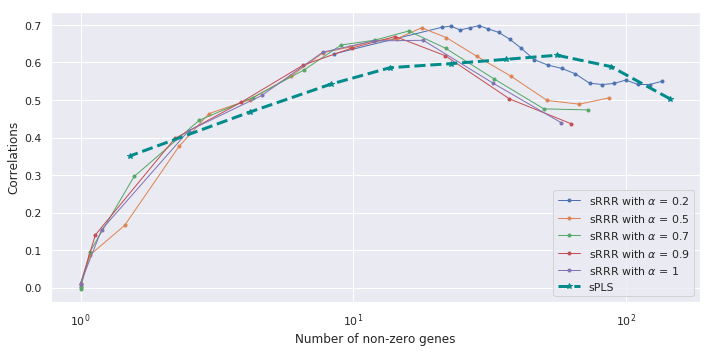

In [9]:
plt.figure(figsize = (10, 5))
plt.plot(n_sRRR[:, 0], c1_sRRR[:, 0], '.-', linewidth=1, label = r'sRRR with $\alpha$ = ' + str(0.2))
plt.plot(n_sRRR[:, 1], c1_sRRR[:, 1], '.-', linewidth=1, label = r'sRRR with $\alpha$ = ' + str(0.5))
plt.plot(n_sRRR[:, 2], c1_sRRR[:, 2], '.-', linewidth=1, label = r'sRRR with $\alpha$ = ' + str(0.7))
plt.plot(n_sRRR[:, 3], c1_sRRR[:, 3], '.-', linewidth=1, label = r'sRRR with $\alpha$ = ' + str(0.9))
plt.plot(n_sRRR[:, 4], c1_sRRR[:, 4], '.-', linewidth=1, label = r'sRRR with $\alpha$ = ' + str(1))
plt.gca().set_prop_cycle(None)
plt.xscale('log')
plt.xlabel('Number of non-zero genes')
plt.ylabel('Correlations')
plt.legend(['sRRR with r$\alpha$=' + str(a) for a in alphas])
plt.plot(n_sPLS, c1_sPLS, '*--', color = 'darkcyan', linewidth = 3, label = 'sPLS')
plt.legend(loc = 'best')
plt.tight_layout()
plt.savefig('CV_sRRR_Witten_comparison.png', dpi = 200)

# sRRR vs Witten et al. sCCA, 2nd correlation component, visual benchmarking

In [28]:
# Kobak et al (sRRR)
# Cross-validation to select lambda and alpha
# Rank = 2, alpha = 1 added

lambdas = np.concatenate([np.arange(.1, 2, .1), np.arange(2, 4)])
alphas = [.2, .5, .7, .9, 1]

r2, r2_relaxed, nonzeros, corrs, corrs_relaxed = sparseRRR.elastic_rrr_cv(X, Y, 
        lambdas=lambdas, alphas=alphas, reps = 5, rank=2, folds=10, seed = 42)

with open('kobakcv_L4_rank_2.pickle', 'wb') as f:
    pickle.dump([r2, r2_relaxed, nonzeros, corrs, corrs_relaxed], f)

1.......... 2.......... 3.......... 4.......... 5.......... Time: 0.0h  8m 40s


In [17]:
def sparsepls_deflated(A, lx = 0, ly = 0):
    # A is a deflated X.T @ Y correlation matrix
    # Written to get the second correlation component
    u,s,v = np.linalg.svd(A, full_matrices=False)
    u = u[:,0]
    v = v[0,:]
    
    for i in range(100):
        unew = softthresh(A @ v, lx)
        if np.linalg.norm(unew) > 0:
            unew = unew / np.linalg.norm(unew)
        vnew = softthresh(A.T @ unew, ly)
        if np.linalg.norm(vnew) > 0:
            vnew = vnew / np.linalg.norm(vnew)
        
        if np.sum((u-unew)**2) + np.sum((v-vnew)**2) < 1e-10:
#             print(i, 'iterations')
            break
        else:
            u = unew
            v = vnew
    
    return (u,v)

In [16]:
def witten_1_2_component_cv(X, Y, reg_params, reps=100, folds=10, seed = 42):
    n = X.shape[0]
    

    testcorrs = np.zeros((2, folds, reps, len(reg_params)))
    nonzero = np.zeros((2, folds, reps, len(reg_params)))

    # CV repetitions
    np.random.seed(seed)
    for rep in range(reps):
        print(rep, end=' ')
        ind = np.random.permutation(n)
        X = X[ind,:]
        Y = Y[ind,:]
        
        # CV folds
        for cvfold in range(folds):
            indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
            indtrain = np.setdiff1d(np.arange(n), indtest)
            Xtrain = np.copy(X[indtrain,:])
            Ytrain = np.copy(Y[indtrain,:])
            Xtest  = np.copy(X[indtest,:])
            Ytest  = np.copy(Y[indtest,:])
            
            # mean centering
            X_mean = np.mean(Xtrain, axis=0)
            Xtrain -= X_mean
            Xtest  -= X_mean
            Y_mean = np.mean(Ytrain, axis=0)
            Ytrain -= Y_mean
            Ytest  -= Y_mean

            # loop over regularization parameters
            for i,r in enumerate(reg_params):    
                vx,vy = sparsepls(Xtrain, Ytrain, lx=r)
                testcorrs[0, cvfold, rep, i] = np.corrcoef((Xtest @ vx).T, (Ytest @ vy).T)[0, 1]
                nonzero[0, cvfold, rep, i] = np.sum(vx!=0)
                d = vx.T @ Xtrain.T @ Ytrain @ vy
                Atrain_deflated = Xtrain.T @ Ytrain - d*(vx[:, np.newaxis] @ vy[:, np.newaxis].T)
                vx_2, vy_2 = sparsepls_deflated(Atrain_deflated, lx = r)
                testcorrs[1, cvfold, rep, i] = np.corrcoef((Xtest @ vx_2).T, (Ytest @ vy_2).T)[0, 1]
                nonzero[1, cvfold, rep, i] = np.sum(vx_2!=0)
    return testcorrs, nonzero

In [19]:
params = np.concatenate([np.arange(34, 79, 5)])
%time corrs, nonzeros = witten_1_2_component_cv(X, Y, params, reps=50)
c = np.nanmean(corrs, axis=(1,2))
n = np.nanmean(nonzeros, axis=(1,2))

0 

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


1 2 3 4 5 6 7 8 9 10 11 

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 CPU times: user 9min 52s, sys: 29min 58s, total: 39min 51s
Wall time: 1min 7s


Optimal param:  44
Optimal n, first component:  54.138
Optimal correlation, first component:  0.616241250357438
Optimal n, second component:  107.386
Optimal correlation, second component:  0.5646228525257464


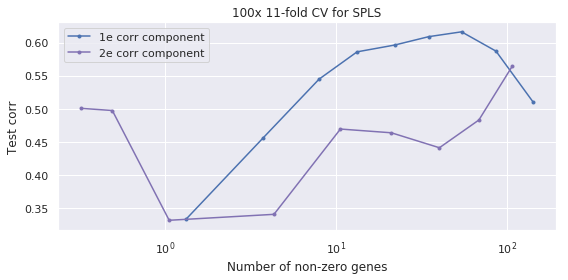

In [20]:
# Pickling Witten et al. sCCA results
with open('witten_1_2_component_cv_L4.pickle', 'wb') as f:
    pickle.dump([c, n, corrs, nonzeros], f)
plt.figure(figsize=(8, 4))
plt.plot(n[0, :], c[0, :], '.-', c = 'b', label = '1e corr component')
plt.plot(n[1, :], c[1, :], '.-', c = 'm', label = '2e corr component')
plt.xscale('log')
plt.title('100x 11-fold CV for SPLS')
plt.xlabel('Number of non-zero genes')
plt.ylabel('Test corr')
plt.legend(loc = 'best')
plt.tight_layout()

print('Optimal param: ', params[np.nanargmax(c)])
print('Optimal n, first component: ', n[0, :][np.nanargmax(c[0, :])])
print('Optimal correlation, first component: ', np.nanmax(c[0, :]))
print('Optimal n, second component: ', n[1, :][np.nanargmax(c[1, :])])
print('Optimal correlation, second component: ', np.nanmax(c[1, :]))

Here we go to visual benchmarking

In [21]:
with open('kobakcv_L4_rank_2.pickle', 'rb') as f:
    r2_sRRR, r2_relaxed_sRRR, nonzeros_sRRR, corrs_sRRR, corrs_relaxed_sRRR = pickle.load(f)

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_sRRR = np.nanmean(nonzeros_sRRR, axis=(0,1))
    cr_sRRR = np.nanmean(r2_relaxed_sRRR, axis=(0,1))
    c_sRRR = np.nanmean(r2_sRRR, axis=(0,1))
    c1_sRRR = np.nanmean(corrs_relaxed_sRRR, axis=(0,1))[:,:,0]
    c2_sRRR = np.nanmean(corrs_relaxed_sRRR, axis=(0,1))[:,:,1]

# Loading sPLS cross validation results
with open('witten_1_2_component_cv_L4.pickle', 'rb') as f:
    c_sPLS, n_sPLS, corrs_sPLS, nonzeros_sPLS = pickle.load(f)

In [22]:
# Remember, in RRR cross validation occured for multiple alpha's
print('c_sPLS shape: ', c_sPLS.shape, '\nc2_sRRR shape: ', c2_sRRR.shape)

c_sPLS shape:  (2, 9) 
c2_sRRR shape:  (21, 5)


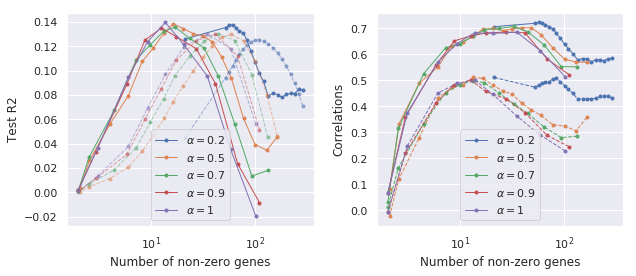

In [36]:
sparseRRR.plot_cv_results(r2, r2_relaxed, nonzero, corrs, corrs_relaxed, alphas)

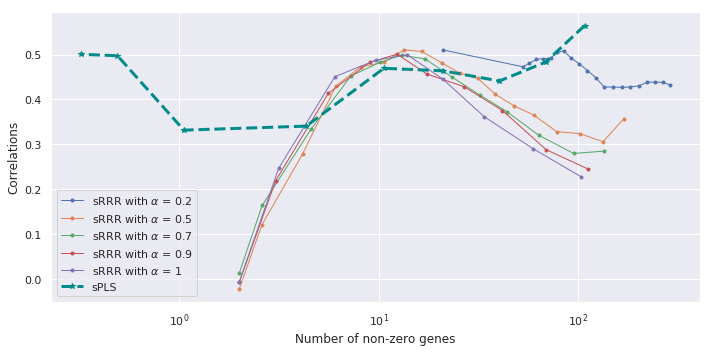

In [23]:
# Comparing the second correlation component
# TODO: Probably should do more reps for sPLS and sRRR

plt.figure(figsize = (10, 5))
plt.plot(n_sRRR[:, 0], c2_sRRR[:, 0], '.-', linewidth=1, label = r'sRRR with $\alpha$ = ' + str(0.2))
plt.plot(n_sRRR[:, 1], c2_sRRR[:, 1], '.-', linewidth=1, label = r'sRRR with $\alpha$ = ' + str(0.5))
plt.plot(n_sRRR[:, 2], c2_sRRR[:, 2], '.-', linewidth=1, label = r'sRRR with $\alpha$ = ' + str(0.7))
plt.plot(n_sRRR[:, 3], c2_sRRR[:, 3], '.-', linewidth=1, label = r'sRRR with $\alpha$ = ' + str(0.9))
plt.plot(n_sRRR[:, 4], c2_sRRR[:, 4], '.-', linewidth=1, label = r'sRRR with $\alpha$ = ' + str(1))
plt.gca().set_prop_cycle(None)
plt.xscale('log')
plt.xlabel('Number of non-zero genes')
plt.ylabel('Correlations')
plt.legend(['sRRR with $\\alpha='+str(a)+'$' for a in alphas])
plt.plot(n_sPLS[1, :], c_sPLS[1, :], '*--', color = 'darkcyan', linewidth = 3, label = 'sPLS')
plt.legend(loc = 'best')
plt.tight_layout()
plt.savefig('CV_sRRR_sPLS_comparison_2nd_component.png', dpi = 200)

In terms of choosing the direction vectors u and v to which we will project the data, we will choose them now for both methods (sRRR and Witten et al. sCCA) according to the max correlation (1st and 2nd component) we could get from them.
Afterwards we will do a comparison if we just want to select approximately 10 genes.

rho_1 =  0.52
rho_2 =  0.33
.................................................................................................... 


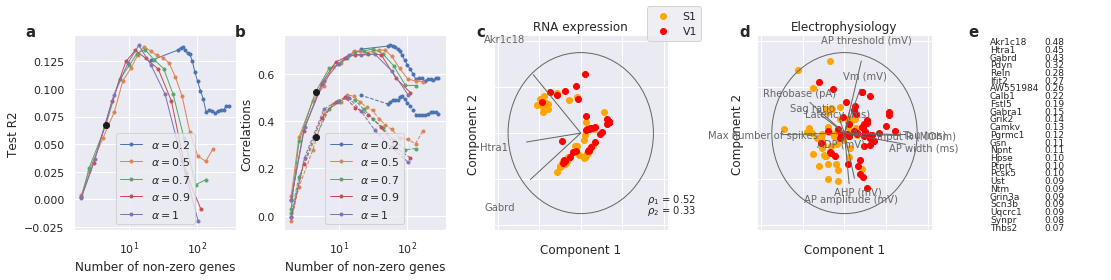

In [53]:
with open('kobakcv_L4_rank_2.pickle', 'rb') as f:
    r2, r2_relaxed, nonzeros, corrs, corrs_relaxed = pickle.load(f)


# Based on the previous cross validation analysis, pick your    
lambda_val = 1.1
alpha_val = .7


# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    c = np.nanmean(r2_relaxed, axis=(0,1))
    n = np.nanmean(nonzeros, axis=(0,1))
    c1 = np.nanmean(corrs_relaxed, axis=(0,1))[:,:,0]
    c2 = np.nanmean(corrs_relaxed, axis=(0,1))[:,:,1]
    
#sns_styleset()
plt.figure(figsize=(15,4))

ax1 = plt.subplot(141)
plt.plot(n, c, '.-', linewidth=1)
plt.xscale('log')
plt.xlabel('Number of non-zero genes')
plt.ylabel('Test R2')
plt.legend(['$\\alpha='+str(a)+'$' for a in alphas])
plt.plot(n[np.isclose(lambdas,lambda_val), np.array(alphas)==alpha_val], 
         c[np.isclose(lambdas,lambda_val), np.array(alphas)==alpha_val], 'ko')

ax2 = plt.subplot(142)
plt.plot(n, c1, '.-', linewidth=1)
plt.gca().set_prop_cycle(None)
plt.plot(n, c2, '.--', linewidth=1)
plt.xscale('log')
plt.xlabel('Number of non-zero genes')
plt.ylabel('Correlations')
plt.legend(['$\\alpha='+str(a)+'$' for a in alphas])
plt.plot(n[np.isclose(lambdas,lambda_val), np.array(alphas)==alpha_val], 
         c1[np.isclose(lambdas,lambda_val), np.array(alphas)==alpha_val], 'ko')
plt.plot(n[np.isclose(lambdas,lambda_val), np.array(alphas)==alpha_val], 
         c2[np.isclose(lambdas,lambda_val), np.array(alphas)==alpha_val], 'ko')
print('rho_1 = ', round(c1[np.isclose(lambdas, lambda_val), np.array(alphas)==alpha_val][0], 2))
print('rho_2 = ', round(c2[np.isclose(lambdas, lambda_val), np.array(alphas)==alpha_val][0], 2))

w,v = sparseRRR.elastic_rrr(X, Y, rank=2, alpha = alpha_val, lambdau = lambda_val)
w[w[:,0]!=0,:],v = sparseRRR.elastic_rrr(X[:,w[:,0]!=0], Y, lambdau = lambda_val, alpha=0, rank=2)

ax3 = plt.subplot(143)
ax4 = plt.subplot(144)

rho_1 = round(c1[np.isclose(lambdas, lambda_val), np.array(alphas)==alpha_val][0], 2)
rho_2 = round(c2[np.isclose(lambdas, lambda_val), np.array(alphas)==alpha_val][0], 2)

sparseRRR.bibiplot_Yves(X, Y, w, v, titles=['RNA expression', 'Electrophysiology'], cellTypes=l4['regions'][selection], \
         cellTypeColors = {'V1':'red','S1':'orange'},
         YdimsNames=l4['ephysNames'], YdimsToShow=np.arange(Y.shape[1]), cellTypeLabels = {'V1':'V1','S1':'S1'},
         XdimsNames=l4['genes'][genesForRRR], XdimsToShow = np.where(w[:,0]!=0)[0],
         xylim = 4.2, scaleFactor = 3.5, corr = np.array([rho_1, rho_2]), axes=(ax3, ax4))



sns.despine()
plt.tight_layout()

pos = ax1.get_position()
ax1.set_position((pos.x0, pos.y0, .15, pos.height))
pos = ax2.get_position()
ax2.set_position((pos.x0 - .05, pos.y0, .15, pos.height))
pos = ax3.get_position()
ax3.set_position((pos.x0 - .1, pos.y0, pos.width, pos.height))
pos = ax4.get_position()
ax4.set_position((pos.x0 - .1, pos.y0, pos.width, pos.height))

bootCounts = sparseRRR.elastic_rrr_bootstrap(X, Y, rank=2, lambdau = lambda_val, alpha = alpha_val)
i = np.argsort(bootCounts)[::-1]
   
with sns.axes_style('white'):
    ax5 = plt.axes((.92, pos.y0, .1, pos.height))
    
    for n, ii in enumerate(i[:25]):
        plt.text(0, 1-(n+1)/25, l4['genes'][genesForRRR][ii], fontsize=9)
        plt.text(0.5, 1-(n+1)/25, '{:.2f}'.format(bootCounts[ii]), fontsize=9)
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    sns.despine(ax=ax5, left=True, bottom=True)
    
plt.text(-.3, 1, 'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=15, fontweight='bold')
plt.text(-.3, 1, 'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=15, fontweight='bold')
plt.text(-.1, 1, 'c', transform = plt.gcf().get_axes()[2].transAxes, fontsize=15, fontweight='bold')
plt.text(-.1, 1, 'd', transform = plt.gcf().get_axes()[3].transAxes, fontsize=15, fontweight='bold')
plt.text(-.2, 1, 'e', transform = plt.gcf().get_axes()[4].transAxes, fontsize=15, fontweight='bold')

plt.savefig('PickingBestRegParamsForsRRR.png', bbox_inches = 'tight', pad_inches = 0.5)

In [40]:
params

array([34, 39, 44, 49, 54, 59, 64, 69, 74])

Optimal param:  44
Optimal n, first component:  54.138
Optimal correlation, first component:  0.616241250357438
Optimal n, second component:  107.386
Optimal correlation, second component:  0.5646228525257464


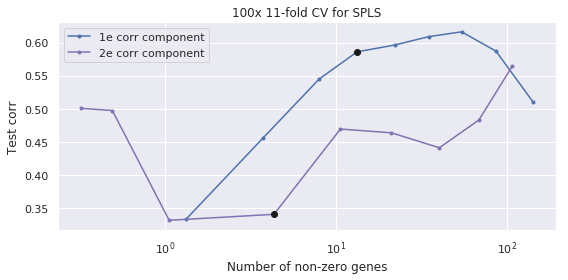

In [108]:
# We can eyeball the following curves as well and look for inspiration
# Note: rank = 2 in sRRR optimises two hidden nodes based on a log loss (XWVT - Y + p(W, V))
# Witten et al. cv optimises first one component, but returns a projection u and v for that then optimises a second component
# and returns a u and v for that (so you have a U = [u1, u2] and a V = [v1, v2])

param = 59
with open('witten_1_2_component_cv_L4.pickle', 'rb') as f:
        c_sPLS, n_sPLS, corrs_sPLS, nonzeros_sPLS = pickle.load(f)
plt.figure(figsize=(8, 4))
plt.plot(n_sPLS[0, :], c_sPLS[0, :], '.-', c = 'b', label = '1e corr component')
plt.plot(n_sPLS[1, :], c_sPLS[1, :], '.-', c = 'm', label = '2e corr component')
plt.plot(n_sPLS[0, np.isclose(params, param)], 
         c_sPLS[0, np.isclose(params, param)], 'ko')
plt.plot(n_sPLS[1, np.isclose(params, param)], 
         c_sPLS[1, np.isclose(params, param)], 'ko')
plt.xscale('log')
plt.title('100x 11-fold CV for SPLS')
plt.xlabel('Number of non-zero genes')
plt.ylabel('Test corr')
plt.legend(loc = 'best')
plt.tight_layout()

print('Optimal param: ', params[np.nanargmax(c_sPLS)])
print('Optimal n, first component: ', n_sPLS[0, :][np.nanargmax(c_sPLS[0, :])])
print('Optimal correlation, first component: ', np.nanmax(c_sPLS[0, :]))
print('Optimal n, second component: ', n_sPLS[1, :][np.nanargmax(c_sPLS[1, :])])
print('Optimal correlation, second component: ', np.nanmax(c_sPLS[1, :]))
plt.savefig('cv_plot_Witten_et_al.png')

In [31]:
# So based on the previous analysis we pick a regularisation parameter value
w_sPLS_1,v_sPLS_1 = sparsepls(X, Y, lx=44)
d = w_sPLS_1.T @ X.T @ Y @ v_sPLS_1
Atrain_deflated = X.T @ Y - d*(w_sPLS_1[:, np.newaxis] @ v_sPLS_1[:, np.newaxis].T)
w_sPLS_2, v_sPLS_2 = sparsepls_deflated(Atrain_deflated, lx = 44)
w_sPLS = np.array([w_sPLS_1, w_sPLS_2]).T
v_sPLS = np.array([v_sPLS_1, v_sPLS_2]).T

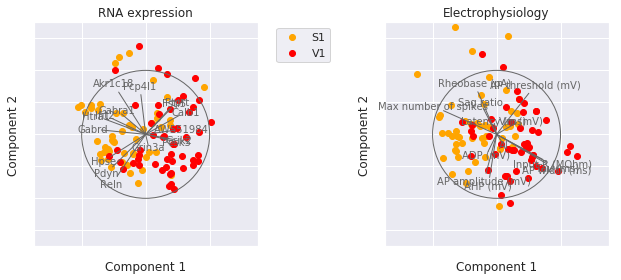

In [24]:
# So based on the previous analysis we pick a lambda and an alpha
w, v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=1.1, alpha=.5)

sparseRRR.bibiplot(X, Y, w, v, 
                   titles=['RNA expression', 'Electrophysiology'],
                   cellTypes=l4['regions'][selection], 
                   cellTypeColors={'V1':'red','S1':'orange'}, 
                   cellTypeLabels = {'V1':'V1','S1':'S1'}, 
                   YdimsNames=l4['ephysNames'], XdimsNames=l4['genes'][genesForRRR],
                   xylim = 3.5, figsize = (16, 5))

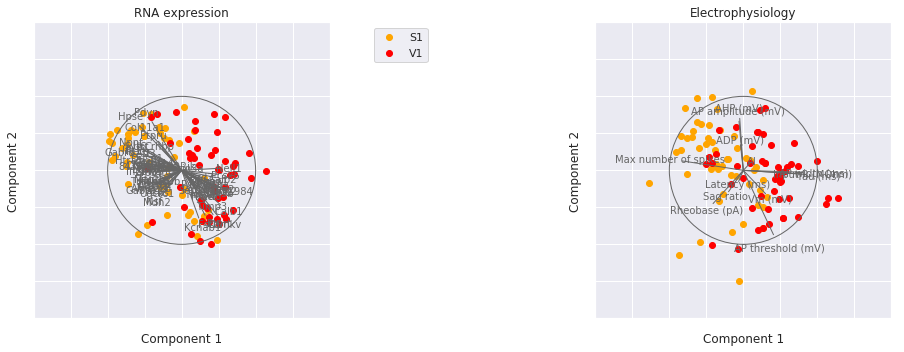

In [36]:
sparseRRR.bibiplot(X, Y, w_sPLS, v_sPLS, 
                   titles=['RNA expression', 'Electrophysiology'],
                   cellTypes=l4['regions'][selection], 
                   cellTypeColors={'V1':'red','S1':'orange'}, 
                   cellTypeLabels = {'V1':'V1','S1':'S1'}, 
                   YdimsNames=l4['ephysNames'], XdimsNames=l4['genes'][genesForRRR],
                   xylim = 4, figsize = (16, 5))
plt.savefig('Witten_et_al_sCCA_bibiplot.png')

Now what if we want approximately +/- 10 genes selected? Do both methods pick similar ones? And considering Witten et al. sCCA, do the gene components selected by the second component correlate highly with the first component because you have performed this deflation?

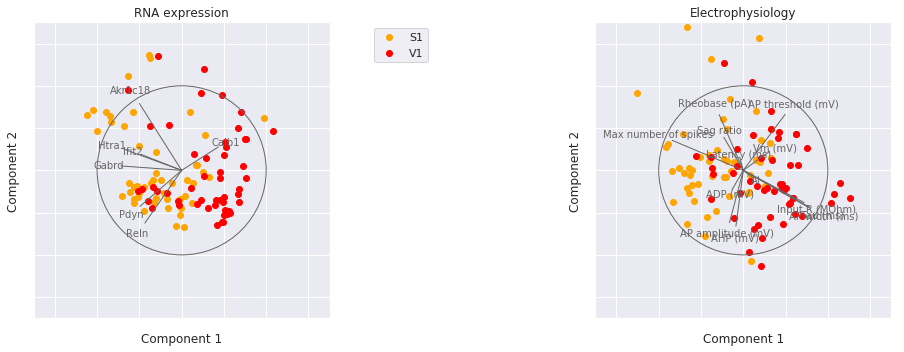

In [104]:
# So based on the previous analysis we pick a lambda and an alpha
w, v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=1.0, alpha=0.7)

sparseRRR.bibiplot(X, Y, w, v, 
                   titles=['RNA expression', 'Electrophysiology'],
                   cellTypes=l4['regions'][selection], 
                   cellTypeColors={'V1':'red','S1':'orange'}, 
                   cellTypeLabels = {'V1':'V1','S1':'S1'}, 
                   YdimsNames=l4['ephysNames'], XdimsNames=l4['genes'][genesForRRR],
                   xylim = 3.5, figsize = (16, 5))
plt.savefig('sRRR_bibiplot_less_genes.png')

In [103]:
import importlib
importlib.reload(sparseRRR)

<module 'sparseRRR' from '/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/L4/ReAnalysis/WithRheobaseAndSag/sparseRRR.py'>

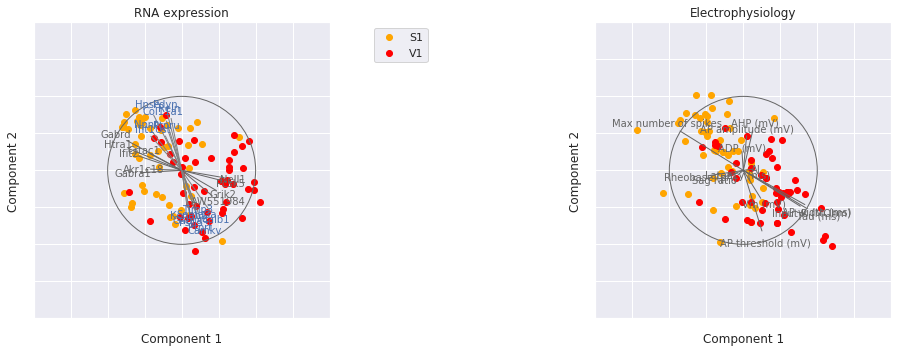

In [106]:
# So based on the previous analysis we pick a regularisation parameter value
w_sPLS_1,v_sPLS_1 = sparsepls(X, Y, lx=69)
d = w_sPLS_1.T @ X.T @ Y @ v_sPLS_1
Atrain_deflated = X.T @ Y - d*(w_sPLS_1[:, np.newaxis] @ v_sPLS_1[:, np.newaxis].T)
w_sPLS_2, v_sPLS_2 = sparsepls_deflated(Atrain_deflated, lx = 59)
w_sPLS = np.array([w_sPLS_1, w_sPLS_2]).T
v_sPLS = np.array([v_sPLS_1, v_sPLS_2]).T

sparseRRR.bibiplot(X, Y, w_sPLS, v_sPLS, 
                   titles=['RNA expression', 'Electrophysiology'],
                   cellTypes=l4['regions'][selection], 
                   cellTypeColors={'V1':'red','S1':'orange'}, 
                   cellTypeLabels = {'V1':'V1','S1':'S1'}, 
                   YdimsNames=l4['ephysNames'], XdimsNames=l4['genes'][genesForRRR],
                   xylim = 4, figsize = (16, 5))
plt.savefig('Witten_et_al_sCCA_bibiplot_less_genes.png')

In [61]:
l4['genes'][genesForRRR][w_sRRR[:, 0] != 0]

array(['Pcp4l1', 'Ptprt', 'Pdyn', 'Fstl5', 'Grin3a', 'Calb1', 'Gabrd',
       'Reln', 'Hpse', 'Htra1', 'AW551984', 'Grik2', 'Gabra1', 'Akr1c18',
       'Pcsk5', 'Ifit2'], dtype=object)

In [62]:
l4['genes'][genesForRRR][w_sRRR[:, 1] != 0]

array(['Pcp4l1', 'Ptprt', 'Pdyn', 'Fstl5', 'Grin3a', 'Calb1', 'Gabrd',
       'Reln', 'Hpse', 'Htra1', 'AW551984', 'Grik2', 'Gabra1', 'Akr1c18',
       'Pcsk5', 'Ifit2'], dtype=object)

In [63]:
l4['genes'][genesForRRR][w_sPLS[:, 0] != 0]

array(['Gabrd', 'Nell1', 'Htra1', 'AW551984', 'Grik2', 'Gabra1',
       'Akr1c18', 'Pcsk5', 'Crtac1', 'Ifit2'], dtype=object)

In [64]:
l4['genes'][genesForRRR][w_sPLS[:, 1] != 0]

array(['Ptprt', 'Pdyn', 'Fstl5', 'Kcnab1', 'Col11a1', 'Npnt', 'Calb1',
       'Ptpru', 'Reln', 'Sema3a', 'Gabra4', 'Hpse', 'Camkv', 'Ust',
       'Timp3', 'Ifit1'], dtype=object)

# sRRR vs Suo et al. sCCA, 1st correlation component

In [1]:
# Suo et al (sCCA)

def softthresh(x,mu):
    return np.sign(x) * np.maximum(np.abs(x) - mu, 0)

def linadmm(a, tau, A = None, lambd=1, mu=1, x0 = None, ridge=0):
    if x0 is None:
        x0 = np.zeros_like(a)
    if A is None:
        A = np.eye(np.size(a))
    
    x = x0
    z = np.zeros(A.shape[0])
    u = np.zeros(A.shape[0])
    for i in range(100):
        xold = np.copy(x)
        x = softthresh((x - mu/lambd * A.T @ (A @ x - z + u) + mu*a)/(1+mu*ridge), mu*tau/(1+mu*ridge))
        z = A @ x + u
        if np.linalg.norm(z) > 1:
            z = z / np.linalg.norm(z)
        u = u + A @ x - z
        if np.sum((x-xold)**2) < 1e-10:
#             print(i, 'admm iterations')
            break
    return x
        

def sparsecca(X,Y,lx=0,ly=0):
    A = X.T @ Y
    u,s,v = np.linalg.svd(A, full_matrices=False)
    u = u[:,0]
    v = v[0,:]
    u = u/np.linalg.norm(X@u)
    v = v/np.linalg.norm(Y@v)
    
    maxEigX = np.max(np.linalg.svd(X, compute_uv=False))
    maxEigY = np.max(np.linalg.svd(Y, compute_uv=False))
    
    for i in range(100):
        # should coincide with sparsepls if None is used instead of X and 1 instead of maxEig
        unew = linadmm(A @ v,      lx, X, 1, 1/maxEigX**2, x0 = u)  
        vnew = linadmm(A.T @ unew, ly, Y, 1, 1/maxEigY**2, x0 = v)
        
        if np.sum((u-unew)**2) + np.sum((v-vnew)**2) < 1e-6:
#             print(i, 'iterations')
            break
        else:
            u = unew
            v = vnew
    
    return (u,v)

In [19]:
def suocv(X, Y, reg_params, reps=100, folds=10, seed = 42):
    n = X.shape[0]
    testcorrs = np.zeros((folds, reps, len(reg_params)))
    nonzero = np.zeros((folds, reps, len(reg_params)))

    # CV repetitions
    np.random.seed(seed)
    for rep in range(reps):
        print(rep, end=' ')
        ind = np.random.permutation(n)
        X = X[ind,:]
        Y = Y[ind,:]
        
        # CV folds
        for cvfold in range(folds):
            indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
            indtrain = np.setdiff1d(np.arange(n), indtest)
            Xtrain = np.copy(X[indtrain,:])
            Ytrain = np.copy(Y[indtrain,:])
            Xtest  = np.copy(X[indtest,:])
            Ytest  = np.copy(Y[indtest,:])
            
            # mean centering
            X_mean = np.mean(Xtrain, axis=0)
            Xtrain -= X_mean
            Xtest  -= X_mean
            Y_mean = np.mean(Ytrain, axis=0)
            Ytrain -= Y_mean
            Ytest  -= Y_mean

            # loop over regularization parameters
            for i,r in enumerate(reg_params):    
                vx,vy = sparsecca(Xtrain, Ytrain, lx=r)
                testcorrs[cvfold, rep, i] = np.corrcoef((Xtest @ vx).T, (Ytest @ vy).T)[0,1]
                nonzero[cvfold, rep, i] = np.sum(vx!=0)
    return testcorrs, nonzero

params = [.1,.5,1,1.5,2, 2.5, 3, 3.5]
%time corrs, nonzeros = suocv(X, Y, params, reps=50)
c = np.nanmean(np.nanmean(corrs, axis=1), axis=0)
n = np.mean(np.mean(nonzeros, axis=1), axis=0)
with open('suocv_L4.pickle', 'wb') as f:
    pickle.dump([c, n, corrs, nonzeros], f)

plt.figure(figsize=(6,3))
plt.plot(n, c, '.-')
plt.xscale('log')
plt.title('50 x 11-fold CV for sCCA')
plt.xlabel('Number of non-zero genes')
plt.ylabel('Test corr')
plt.tight_layout()

print('Optimal param: ', params[np.nanargmax(c)])
print('Optimal n: ', n[np.nanargmax(c)])
print('Optimal correlation: ', np.nanmax(c))

0 1 2 3 4 

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


5 6 7 

KeyboardInterrupt: 

NameError: name 'corrs' is not defined

In [16]:
# HERE WE PLOT THE FIRST COMPONENENT VS EACH OTHER, YOU COULD ALSO LOAD FROM THE CROSS VALIDATIONS THAT CALCULATED
# BOTH COMPONENTS (SEE FURTHER)

# Loading sRRR cross validation results

with open('kobakcv_L4.pickle', 'rb') as f:
    r2_sRRR, r2_relaxed_sRRR, nonzeros_sRRR, corrs_sRRR, corrs_relaxed_sRRR = pickle.load(f)

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_sRRR = np.nanmean(nonzeros_sRRR, axis=(0,1))
    cr_sRRR = np.nanmean(r2_relaxed_sRRR, axis=(0,1))
    c_sRRR = np.nanmean(r2_sRRR, axis=(0,1))
    c1_sRRR = np.nanmean(corrs_relaxed_sRRR, axis=(0,1))[:,:,0]
    #c2_sRRR = np.nanmean(corrs_relaxed_sRRR, axis=(0,1))[:,:,1]

# Loading sPLS cross validation results
with open('witten_cv_L4.pickle', 'rb') as f:
    c1_sPLS, n_sPLS, corrs_sPLS, nonzeros_sPLS = pickle.load(f)
    
# Loading sCCA cross validation results
with open('suocv_L4.pickle', 'rb') as f:
    c1_sCCA, n_sCCA, corrs_sCCA, nonzeros_sCCA = pickle.load(f)

In [17]:
# Remember, in RRR cross validation occured for multiple alpha's
print('c_sPLS shape: ', c1_sPLS.shape, '\nc_sCCA shape: ', c1_sCCA.shape, '\nc_sRRR shape: ', c1_sRRR.shape)

c_sPLS shape:  (2, 9) 
c_sCCA shape:  (2, 8) 
c_sRRR shape:  (21, 5)


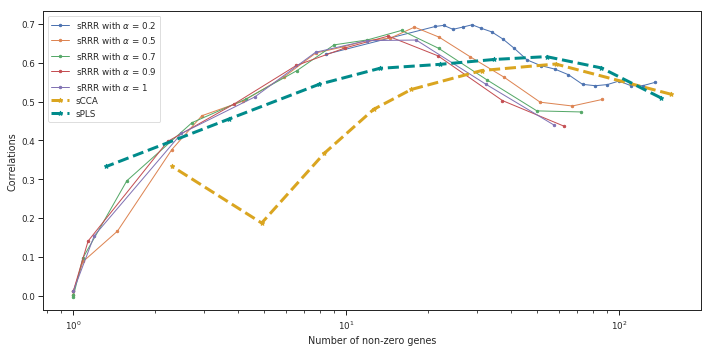

In [18]:
%matplotlib inline
def sns_styleset():
    sns.set_style('ticks', {'axes.linewidth': .75, "xtick.major.size":4, "ytick.major.size":4})
sns_styleset()
plt.figure(figsize = (10, 5))
plt.plot(n_sRRR[:, 0], c1_sRRR[:, 0], '.-', linewidth=1, label = r'sRRR with $\alpha$ = ' + str(0.2))
plt.plot(n_sRRR[:, 1], c1_sRRR[:, 1], '.-', linewidth=1, label = r'sRRR with $\alpha$ = ' + str(0.5))
plt.plot(n_sRRR[:, 2], c1_sRRR[:, 2], '.-', linewidth=1, label = r'sRRR with $\alpha$ = ' + str(0.7))
plt.plot(n_sRRR[:, 3], c1_sRRR[:, 3], '.-', linewidth=1, label = r'sRRR with $\alpha$ = ' + str(0.9))
plt.plot(n_sRRR[:, 4], c1_sRRR[:, 4], '.-', linewidth=1, label = r'sRRR with $\alpha$ = ' + str(1))
plt.gca().set_prop_cycle(None)
plt.xscale('log')
plt.xlabel('Number of non-zero genes')
plt.ylabel('Correlations')
plt.legend(['sRRR with r$\alpha='+str(a)+'$' for a in alphas])
plt.plot(n_sCCA, c1_sCCA, '*--', color = 'goldenrod', linewidth = 3, label = 'sCCA')
plt.plot(n_sPLS, c1_sPLS, '*--', color = 'darkcyan', linewidth = 3, label = 'sPLS')
plt.legend(loc = 'best')
plt.tight_layout()
#plt.savefig('CV_sRRR_sCCA_sPLS_comparison.png', dpi = 200)

# Suo, Witten, sRRR second correlation component, visual benchmarking

You could also plot the first and second component again from witten_1_2_component_cv_L4.pickle and suo_1_2_component_cv_L4.pickle. Note: plot n_sCCA[0, :] vs c1_sCCA[0, :] and n_sPLS[1, :] vs c1_sPLS[1,:] then...

In [ ]:
# This would be cross validation for first and second comonent simultaneously. Not sure if this code is correct.
def suo_1_2_component_cv(X, Y, reg_params, reps=100, folds=10, seed = 42):
    n = X.shape[0]
    testcorrs = np.zeros((2, folds, reps, len(reg_params)))
    nonzero = np.zeros((2, folds, reps, len(reg_params)))

    # CV repetitions
    np.random.seed(seed)
    for rep in range(reps):
        print('\n', rep, end=' ')
        ind = np.random.permutation(n)
        X = X[ind,:]
        Y = Y[ind,:]
        
        # CV folds
        for cvfold in range(folds):
            indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
            indtrain = np.setdiff1d(np.arange(n), indtest)
            Xtrain = np.copy(X[indtrain,:])
            Ytrain = np.copy(Y[indtrain,:])
            Xtest  = np.copy(X[indtest,:])
            Ytest  = np.copy(Y[indtest,:])
            
            # mean centering
            X_mean = np.mean(Xtrain, axis=0)
            Xtrain -= X_mean
            Xtest  -= X_mean
            Y_mean = np.mean(Ytrain, axis=0)
            Ytrain -= Y_mean
            Ytest  -= Y_mean

            # loop over regularization parameters
            for i,r in enumerate(reg_params):
                print('\treg_param: ', r)
                vx,vy = sparsecca(Xtrain, Ytrain, lx=r)
                testcorrs[0, cvfold, rep, i] = np.corrcoef((Xtest @ vx).T, (Ytest @ vy).T)[0,1]
                nonzero[0, cvfold, rep, i] = np.sum(vx!=0)
                X_ = np.concatenate((Xtrain, vx[:, np.newaxis].T @ X.T @ X), axis = 0)
                Y_ = np.concatenate((Ytrain, vy[:, np.newaxis].T @ Y.T @ Y), axis = 0)
                print('\tX_.shape: ', X_.shape)
                print('\tY_.shape: ', Y_.shape)
                vx_2, vy_2 = sparsecca(X_, Y_, lx = r)
                testcorrs[1, cvfold, rep, i] = np.corrcoef((Xtest @ vx_2).T, (Ytest @ vy_2).T)[0, 1]
                nonzero[1, cvfold, rep, i] = np.sum(vx_2!=0)
    return testcorrs, nonzero

In [ ]:
params = [.1,.5,1,1.5,2, 2.5, 3, 3.5]
%time corrs, nonzeros = suo_1_2_component_cv(X, Y, params, reps=1)

In [ ]:
c = np.nanmean(corrs, axis=(1, 2))
n = np.nanmean(nonzeros, axis=(1, 2))
with open('suo_1_2_component_cv_L4.pickle', 'wb') as f:
    pickle.dump([c, n, corrs, nonzeros], f)